In [34]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import minimize


# Risk-free rate odnosi się do teoretycznego zwrotu z inwestycji, która nie niesie ze sobą ryzyka utraty kapitału.
# W praktyce często kojarzy się z rentownością obligacji rządowych, zwłaszcza tych emitowanych przez stabilne finansowo państwa.
# W projekcie korzystam z rentowności 3-miesięcznych obligacji skarbowych USA, które są uważane za bezpieczne aktywa.
rf_rate = yf.download('^IRX').iloc[-1, 3] / 100
print('Risk-free rate: {:.2f}%'.format(rf_rate * 100))

# Współczynnik Sharpe'a to proporcja między nadwyżką stopy zwrotu inwestycji a jej ryzykiem.
# Im wyższy współczynnik, tym 'lepsza' inwestycja.
def Sharpe(data, weights, rf_rate=0):
    mean = np.mean(data, axis=0)
    return (mean - rf_rate) @ weights / np.sqrt(weights @ np.cov(data.T) @ weights)

[*********************100%%**********************]  1 of 1 completed
Risk-free rate: 5.22%


# Zadanie 3
## teoria portfelowa i badanie efektu dywersyfikacji

Korzystając z modelu Markowitza, proszę o analizę relacji potencjalnego zysku do ryzyka w odniesieniu do portfela złożonego z ryzykownych instrumentów finansowych. Proszę wyznaczyć zbiór portfeli efektywnych (efficient portfolios) oraz granicę efektywną (efficient frontier).

**Model Markowitza** (model średniej-wariancji) to model zakładający, że inwestor, budując portfel inwestycyjny, chce zwiększać przewidywany zysk podejmując najmniejsze możliwe ryzyko. Jako ryzyko w modelu Markowitza rozumie się *wariancję*, a poziom zysku - przez *średni zwrot*.

### Wizualizacja szeregów czasowych

[*********************100%%**********************]  2 of 2 completed


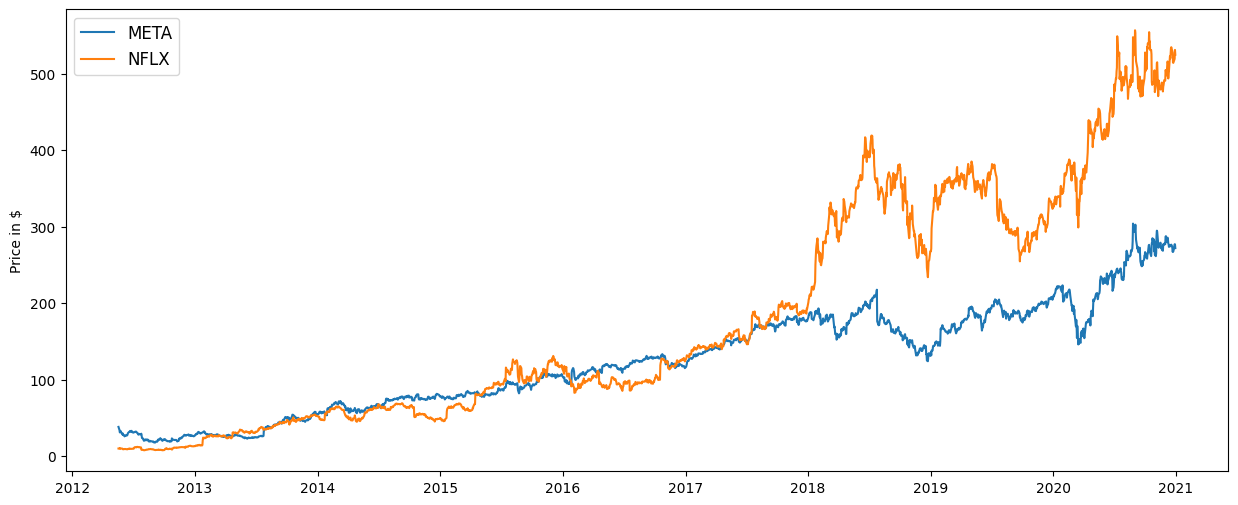

Text(0, 0.5, 'Daily returns')

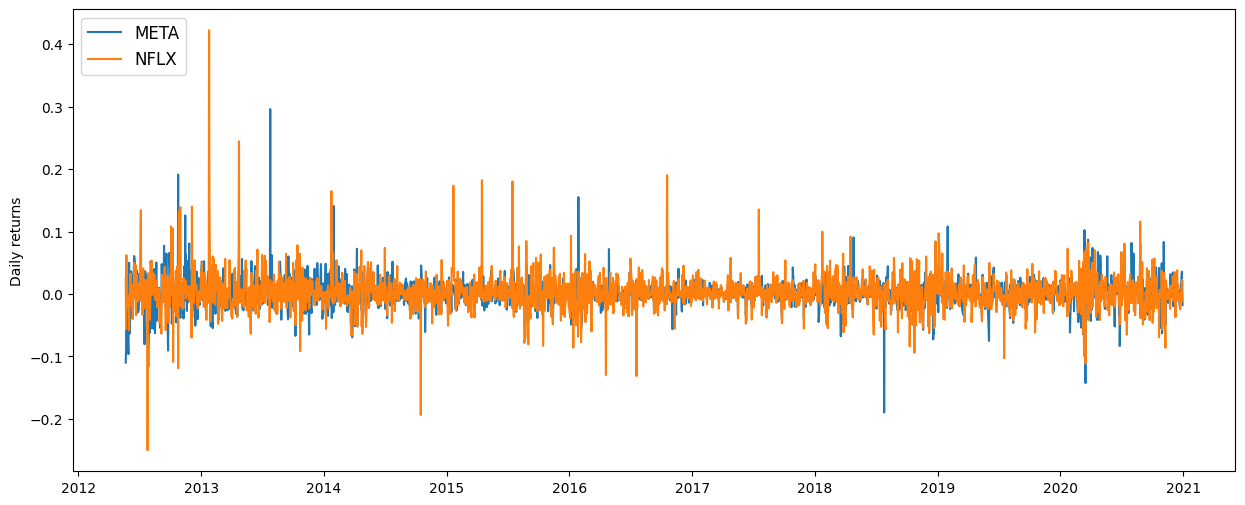

In [35]:
# W projekcie używam danych z serwisu Yahoo Finance, który dostarcza dane historyczne o cenach akcji.
# Wczytuję dane o cenach zamknięcia akcji spółek Ford, Apple, Netflix i META.
data = yf.download('NFLX META', start='2010-01-01', end='2020-12-31')['Adj Close'].dropna()

plt.figure(figsize=(15, 6))
for i in range(data.shape[1]):
    plt.plot(data.iloc[:,i], label=data.columns.values[i])
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('Price in $')
plt.show()

plt.figure(figsize=(15, 6))
returns = data.pct_change().dropna()
for i in range(returns.shape[1]):
    plt.plot(returns.iloc[:,i], label=returns.columns.values[i])
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('Daily returns')

In [36]:
# Obliczam aar (average annual return) i macierz kowariancji dla zwrotów.
aar = returns.mean() * 252
rcov = returns.cov()

print('Annual mean return:\n', aar, '\n')
print('Covariance matrix:\n', rcov)

Annual mean return:
 META    0.297390
NFLX    0.572123
dtype: float64 

Covariance matrix:
           META      NFLX
META  0.000556  0.000204
NFLX  0.000204  0.000907


### przydatne funkcje

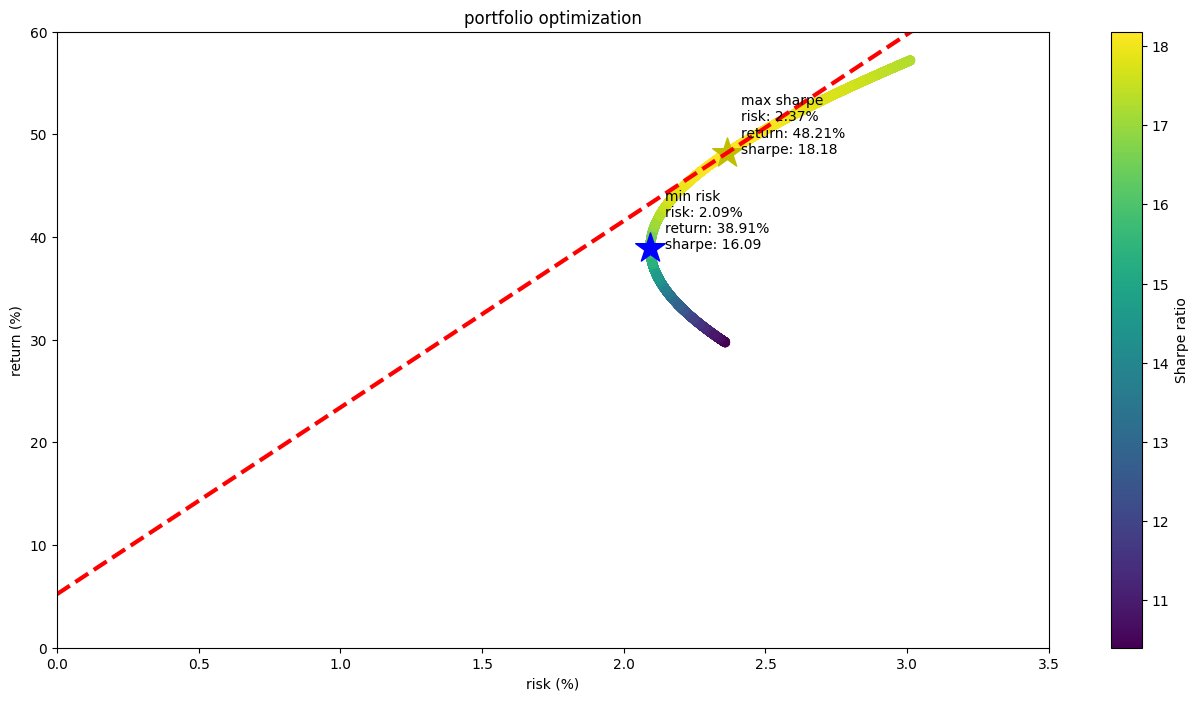

In [37]:
N_PORTFOLIOS = 10000

# Generuję losowe wagi dla portfeli, obliczam ich średnią roczną stopę zwrotu, ryzyko i współczynnik Sharpe'a.
def generate_portfolios(mean_returns, cov_matrix):
    returns = []
    risks = []
    sharpes = []
    weights = []
    for _ in range(N_PORTFOLIOS):
        weights.append(np.random.dirichlet(np.ones(mean_returns.shape[0]), size=1)[0])
        returns.append(weights[-1] @ mean_returns)
        risks.append(np.sqrt(weights[-1].T @ cov_matrix @ weights[-1]))
        sharpes.append((returns[-1] - rf_rate) / risks[-1])
    returns = np.array(returns) * 100
    risks = np.array(risks) * 100
    return risks, returns, sharpes

# Obliczam MCL - minimum capital line, która jest linią łączącą punkt o zwrocie równej stopie zwrotu bezryzykownego z portfelem o najwyższym współczynniku Sharpe'a.
def generate_mcl(x, mean_returns, cov_matrix):
    risks, returns, sharpes = generate_portfolios(mean_returns, cov_matrix)
    max_sharpe_idx = np.argmax(sharpes)
    y = (returns[max_sharpe_idx] - rf_rate * 100) / risks[max_sharpe_idx] * x + rf_rate * 100
    return y

# Obliczam portfele o najwyższym współczynniku Sharpe'a i najmniejszym ryzyku.
def generate_optimal_portfolio(mean_returns, cov_matrix):
    risks, returns, sharpes = generate_portfolios(mean_returns, cov_matrix)
    max_sharpe_idx = np.argmax(sharpes)
    min_risk_idx = np.argmin(risks)
    return (risks[max_sharpe_idx], returns[max_sharpe_idx], sharpes[max_sharpe_idx]), \
           (risks[min_risk_idx], returns[min_risk_idx], sharpes[min_risk_idx])

plt.figure(figsize=(16, 8))
plt.title("portfolio optimization")
plt.xlabel("risk (%)")
plt.ylabel("return (%)")
risks, returns, sharpes = generate_portfolios(aar, rcov)
plt.scatter(risks, returns, c=sharpes, cmap='viridis')
plt.colorbar(label='Sharpe ratio')
x = np.linspace(0, 3.5, N_PORTFOLIOS)
plt.plot(x, generate_mcl(x, aar, rcov), 'r--', lw=3)
p1, p2 = generate_optimal_portfolio(aar, rcov)
plt.scatter(p1[0], p1[1], c='y', marker='*', s=500)
plt.text(p1[0] + 0.05, p1[1] - 0.05, 'max sharpe\nrisk: {:.2f}%\nreturn: {:.2f}%\nsharpe: {:.2f}'.format(p1[0], p1[1], p1[2]))
plt.scatter(p2[0], p2[1], c='b', marker='*', s=500)
plt.text(p2[0] + 0.05, p2[1] - 0.05, 'min risk\nrisk: {:.2f}%\nreturn: {:.2f}%\nsharpe: {:.2f}'.format(p2[0], p2[1], p2[2]))

plt.ylim(0, 60)
plt.xlim(0, 3.5)
plt.show()

Na powyższym wykresie widzimy zbiór możliwych portfeli (generowany przez losowanie wag przypisanych elementom portfela), który rysuje nam granicę efektywną. Oprócz tego widzimy najlepsze portfele pod względem stosunku (średni zwrot/ryzyko) oraz samego ryzyka. Czerwoną, przerywaną linią została zaznaczona MCL, linia rynku kapitałowego, która jest styczną do granicy efektywnej wychodzącą z punktu (risk-free rate, 0).

### dodanie możliwości krótkiej sprzedaży

Krótka sprzedaż to sposób na uzyskanie przychodu przez spadek wartości papierów wartościowych. Inwestor przyjmuje, że ceny akcji będą spadały, co pozwoli mu na korzystny ponowny zakup akcji uprzednio sprzedanych. W algorytmie krótką sprzedaż oznaczam wagami ujemnymi.

[*********************100%%**********************]  4 of 4 completed


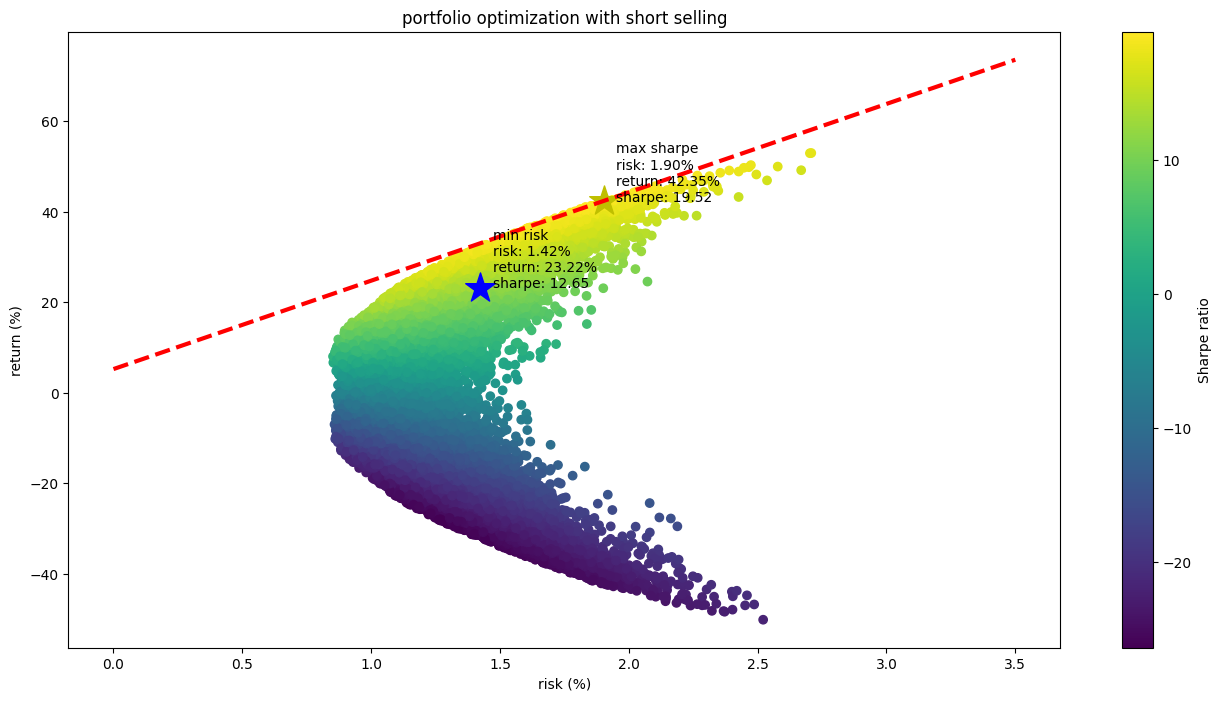

In [38]:
# Wczytuję dane o cenach zamknięcia akcji spółek Ford, Apple, Netflix i META.
data = yf.download('F AAPL NFLX META', start='2010-01-01', end='2020-12-31')['Adj Close'].dropna()
returns = data.pct_change().dropna()
aar = returns.mean() * 252
rcov = returns.cov()

# generowanie portfeli o losowych wagach dodając możliwość krótkiej sprzedaży
def generate_portfolios_short(mean_returns, cov_matrix):
    returns = []
    risks = []
    sharpes = []
    weights = []
    for _ in range(N_PORTFOLIOS * 2):
        w = np.random.random(mean_returns.shape[0])
        w = w * 2 - 1
        w = w / np.sum(np.abs(w))
        weights.append(w)
        returns.append(weights[-1] @ mean_returns)
        risks.append(np.sqrt(weights[-1].T @ cov_matrix @ weights[-1]))
        sharpes.append((returns[-1] - rf_rate) / risks[-1])
    returns = np.array(returns) * 100
    risks = np.array(risks) * 100
    return risks, returns, sharpes

plt.figure(figsize=(16, 8))
plt.title("portfolio optimization with short selling")
plt.xlabel("risk (%)")
plt.ylabel("return (%)")
risks, returns, sharpes = generate_portfolios_short(aar, rcov)
plt.scatter(risks, returns, c=sharpes, cmap='viridis')
plt.colorbar(label='Sharpe ratio')
x = np.linspace(0, 3.5, N_PORTFOLIOS * 2)
plt.plot(x, generate_mcl(x, aar, rcov), 'r--', lw=3)
p1, p2 = generate_optimal_portfolio(aar, rcov)
plt.scatter(p1[0], p1[1], c='y', marker='*', s=500)
plt.text(p1[0] + 0.05, p1[1] - 0.05, 'max sharpe\nrisk: {:.2f}%\nreturn: {:.2f}%\nsharpe: {:.2f}'.format(p1[0], p1[1], p1[2]))
plt.scatter(p2[0], p2[1], c='b', marker='*', s=500)
plt.text(p2[0] + 0.05, p2[1] - 0.05, 'min risk\nrisk: {:.2f}%\nreturn: {:.2f}%\nsharpe: {:.2f}'.format(p2[0], p2[1], p2[2]))
plt.show()

### powtórzenie ćwiczenia dla instrumentu ryzykownego + instrumentu o stałym dochodzie

[*********************100%%**********************]  2 of 2 completed


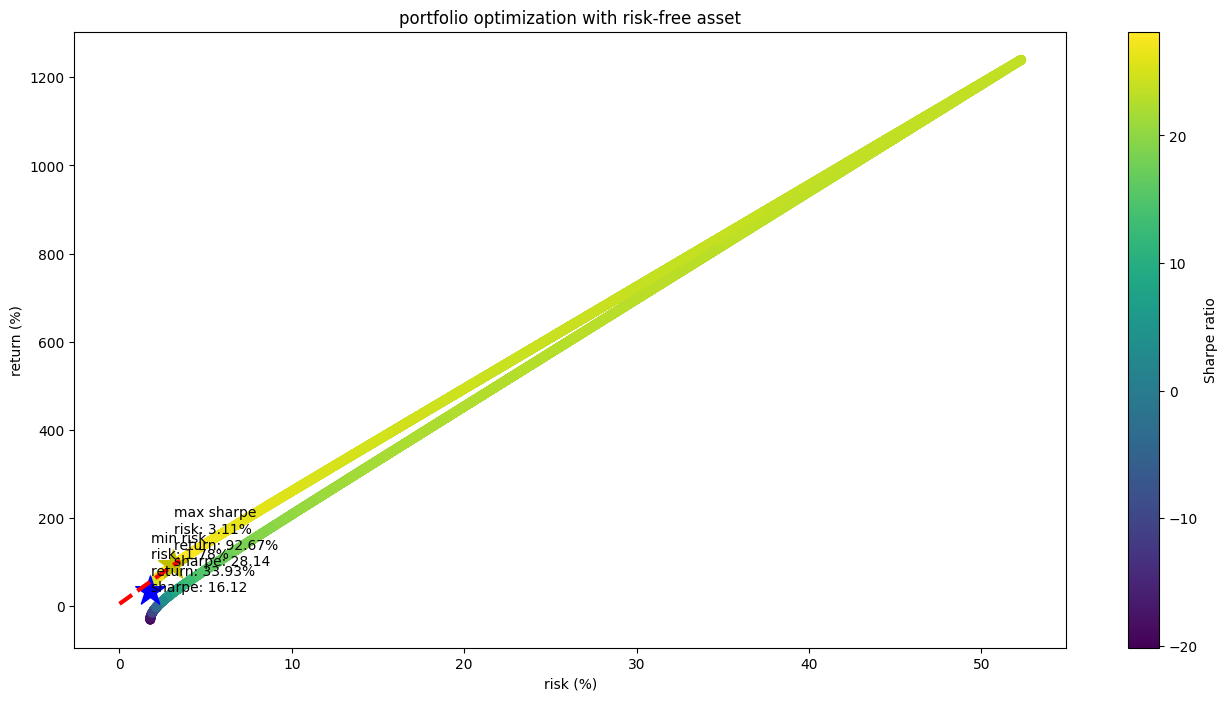

In [39]:
# importowanie danych o instrumencie ryzykownym (akcje) i bezryzykowym (obligacje)
data = yf.download('AAPL ^IRX', start='2010-01-01', end='2020-12-31')['Adj Close'].dropna()
returns = data.pct_change().dropna()
aar = returns.mean() * 252
rcov = returns.cov()

# generowanie portfeli o losowych wagach z możliwością krótkiej sprzedaży (tylko akcje)
def generate_portfolios_short(mean_returns, cov_matrix):
    returns = []
    risks = []
    sharpes = []
    weights = []
    for _ in range(N_PORTFOLIOS * 2):
        w = np.random.random(mean_returns.shape[0])
        w[0] = w[0] * 2 - 1
        w = w / np.sum(np.abs(w))
        weights.append(w)
        returns.append(weights[-1] @ mean_returns)
        risks.append(np.sqrt(weights[-1].T @ cov_matrix @ weights[-1]))
        sharpes.append((returns[-1] - rf_rate) / risks[-1])
    returns = np.array(returns) * 100
    risks = np.array(risks) * 100
    return risks, returns, sharpes


plt.figure(figsize=(16, 8))
plt.title("portfolio optimization with risk-free asset")
plt.xlabel("risk (%)")
plt.ylabel("return (%)")
risks, returns, sharpes = generate_portfolios_short(aar, rcov)
plt.scatter(risks, returns, c=sharpes, cmap='viridis')
plt.colorbar(label='Sharpe ratio')
x = np.linspace(0, 3.5, N_PORTFOLIOS)
plt.plot(x, generate_mcl(x, aar, rcov), 'r--', lw=3)
p1, p2 = generate_optimal_portfolio(aar, rcov)
plt.scatter(p1[0], p1[1], c='y', marker='*', s=500)
plt.text(p1[0] + 0.05, p1[1] - 0.05, 'max sharpe\nrisk: {:.2f}%\nreturn: {:.2f}%\nsharpe: {:.2f}'.format(p1[0], p1[1], p1[2]))
plt.scatter(p2[0], p2[1], c='b', marker='*', s=500)
plt.text(p2[0] + 0.05, p2[1] - 0.05, 'min risk\nrisk: {:.2f}%\nreturn: {:.2f}%\nsharpe: {:.2f}'.format(p2[0], p2[1], p2[2]))
plt.show()

### powtórzenie ćwiczenia dla wielu ryzykownych aktywów

[*********************100%%**********************]  6 of 6 completed


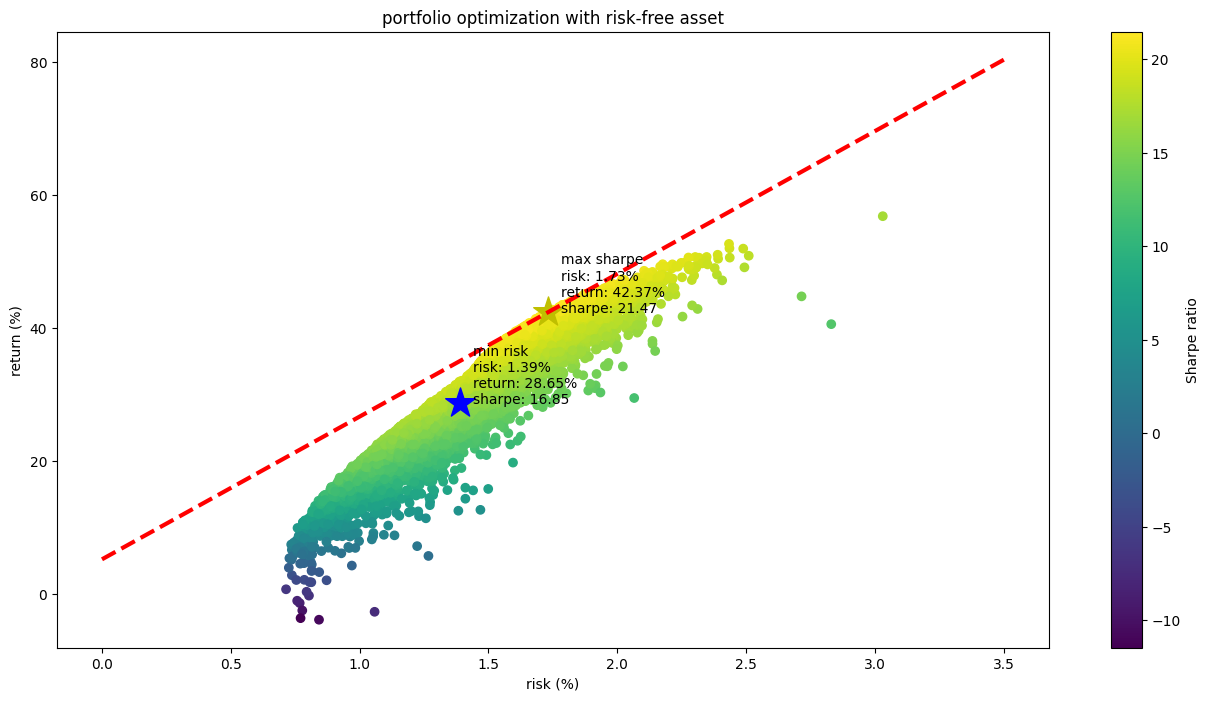

In [40]:
# wczytanie danych o 6 różnych aktywach 
data = yf.download('AAPL MSFT NFLX TSLA GOOGL AMZN', start='2010-01-01', end='2020-12-31')['Adj Close'].dropna()
returns = data.pct_change().dropna()
aar = returns.mean() * 252
rcov = returns.cov()

plt.figure(figsize=(16, 8))
plt.title("portfolio optimization with risk-free asset")
plt.xlabel("risk (%)")
plt.ylabel("return (%)")
risks, returns, sharpes = generate_portfolios_short(aar, rcov)
plt.scatter(risks, returns, c=sharpes, cmap='viridis')
plt.colorbar(label='Sharpe ratio')
x = np.linspace(0, 3.5, N_PORTFOLIOS)
plt.plot(x, generate_mcl(x, aar, rcov), 'r--', lw=3)
p1, p2 = generate_optimal_portfolio(aar, rcov)
plt.scatter(p1[0], p1[1], c='y', marker='*', s=500)
plt.text(p1[0] + 0.05, p1[1] - 0.05, 'max sharpe\nrisk: {:.2f}%\nreturn: {:.2f}%\nsharpe: {:.2f}'.format(p1[0], p1[1], p1[2]))
plt.scatter(p2[0], p2[1], c='b', marker='*', s=500)
plt.text(p2[0] + 0.05, p2[1] - 0.05, 'min risk\nrisk: {:.2f}%\nreturn: {:.2f}%\nsharpe: {:.2f}'.format(p2[0], p2[1], p2[2]))
plt.show()

### dodanie wskaźnika treynora

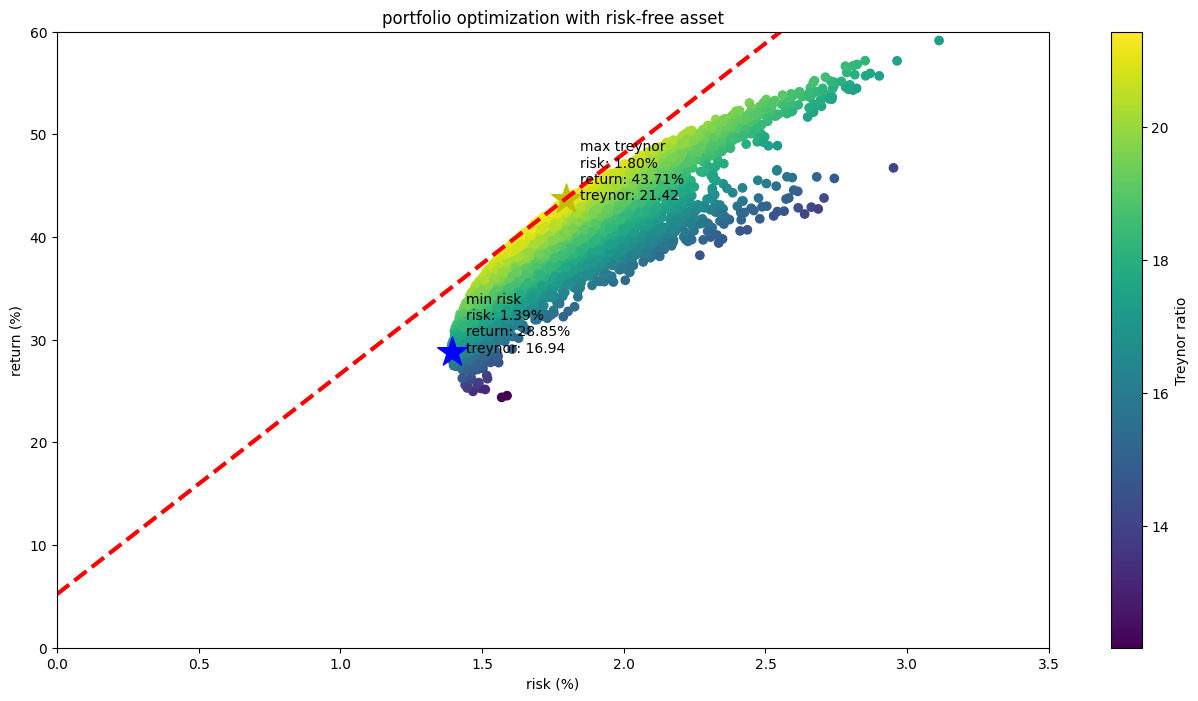

In [46]:
# wskaźnik treynor'a, pozwalający ocenić wysokość premii uzyskiwanej z danego portfela inwestycyjnego przez inwestora w stosunku do poniesionego ryzyka.
def Treynor(data, weights, rf_rate=0):
    mean = np.mean(data, axis=0)
    return (mean - rf_rate) @ weights / np.sqrt(weights @ np.cov(data.T) @ weights)

def generate_portfolios_treynor(mean_returns, cov_matrix): 
    returns = []
    risks = []
    treynors = []
    weights = []
    for _ in range(N_PORTFOLIOS):
        weights.append(np.random.dirichlet(np.ones(mean_returns.shape[0]), size=1)[0])
        returns.append(weights[-1] @ mean_returns)
        risks.append(np.sqrt(weights[-1].T @ cov_matrix @ weights[-1]))
        treynors.append((returns[-1] - rf_rate) / risks[-1])
    returns = np.array(returns) * 100
    risks = np.array(risks) * 100
    return risks, returns, treynors

plt.figure(figsize=(16, 8))
plt.title("portfolio optimization with risk-free asset")
plt.xlabel("risk (%)")
plt.ylabel("return (%)")
risks, returns, treynors = generate_portfolios_treynor(aar, rcov)
plt.scatter(risks, returns, c=treynors, cmap='viridis')
plt.colorbar(label='Treynor ratio')
x = np.linspace(0, 3.5, N_PORTFOLIOS)
plt.plot(x, generate_mcl(x, aar, rcov), 'r--', lw=3)
p1, p2 = generate_optimal_portfolio(aar, rcov)
plt.scatter(p1[0], p1[1], c='y', marker='*', s=500)
plt.text(p1[0] + 0.05, p1[1] - 0.05, 'max treynor\nrisk: {:.2f}%\nreturn: {:.2f}%\ntreynor: {:.2f}'.format(p1[0], p1[1], p1[2]))
plt.scatter(p2[0], p2[1], c='b', marker='*', s=500)
plt.text(p2[0] + 0.05, p2[1] - 0.05, 'min risk\nrisk: {:.2f}%\nreturn: {:.2f}%\ntreynor: {:.2f}'.format(p2[0], p2[1], p2[2]))
plt.xlim(0, 3.5)
plt.ylim(0, 60)
plt.show()
